In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye import oechem, oedepict

from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit

from fragmenter import torsions, chemi
import numpy as np

from autograd import grad
from autograd import numpy as np

In [3]:
# Create openeye molecules and add conformers with torsion angle at 15 degree intervals
smiles = ['c1cc(ccc1c2ccncc2)O', 'c1cc(ccc1c2cc[nH+]cc2)O', 'c1cc(ccc1c2ccncc2)[O-]', 'c1cc(ccc1c2cc[nH+]cc2)[O-]']
names = ['neutral', 'cation', 'anion', 'zwitterion']
# Create openeye molecules
oemols = [chemi.smiles_to_oemol(sm, add_atom_map=True) for sm in smiles]
for i, mol in enumerate(oemols):
    mol.SetTitle(names[i])
    
conf_mols = []
# Find torsion to constrain
for mol in oemols:
    for bond in mol.GetBonds():
        if bond.IsRotor():
            rot_bond = bond
            break
    bond_map = (rot_bond.GetBgn().GetMapIdx(), rot_bond.GetEnd().GetMapIdx())
    dih = torsions.find_torsion_around_bond(molecule=mol, bond=bond_map)
    conformers = chemi.generate_grid_conformers(mol, dihedrals=[dih], intervals=[15])
    conf_mols.append(conformers)

In [4]:
off_molecules = [Molecule.from_openeye(mol) for mol in conf_mols]
topologies = [Topology.from_molecules(mol) for mol in off_molecules]
forcefield = ForceField('openff-1.0.0.offxml')



In [5]:
for i, top in enumerate(topologies):
    print('\n')
    print(off_molecules[i])
    molecule_force_list = forcefield.label_molecules(top)
    for mol_idx, mol_forces in enumerate(molecule_force_list):
        print(f'Forces for molecule {mol_idx}')
        for force_tag, force_dict in mol_forces.items():
            if force_tag != 'ProperTorsions':
                continue
            print(f"\n{force_tag}:")
            for (atom_indices, parameter) in force_dict.items():
                if atom_indices == tuple(dih):
                    atomstr=''
                    for idx in atom_indices:
                        atomstr += '%3s' % idx
                    print("atoms: %s  parameter_id: %s  smirks %s" % (atomstr, parameter.id, parameter.smirks) )




Molecule with name 'neutral' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'cation' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])O[H])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'anion' and SMILES '[H]c1c(c(c(c(c1c2c(c(nc(c2[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


Molecule with name 'zwitterion' and SMILES '[H]c1c(c(c(c(c1c2c(c([n+](c(c2[H])[H])[H])[H])[H])[H])[H])[O-])[H]'
Forces for molecule 0

ProperTorsions:
atoms:   0  8  9  4  parameter_id: t43  smirks [*:1]~[#6X3:2]-[#6X3:3]~[*:4]


In [6]:
# Create OMM systems
from simtk import openmm, unit

#integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

systems = [forcefield.create_openmm_system(top) for top in topologies]
simulations = [openmm.app.Simulation(topologies[i], systems[i], mm.VerletIntegrator(1*unit.femtosecond)) for i in range(4)]

In [7]:
all_energies = []
all_angles = []
for i, mol in enumerate(off_molecules):
    energies = []
    angles = []
    for j in range(24):
        simulation = simulations[i]
        angles.append(torsions.measure_dihedral_angle(coords=mol.conformers[j]._value, dihedral=dih))
        simulation.context.setPositions(mol.conformers[j])
        state = simulation.context.getState(getEnergy=True)
        energy = state.getPotentialEnergy()
        energies.append(energy._value)
    energies = np.asanyarray(energies) - min(energies)
    all_energies.append(energies)
    all_angles.append(angles)

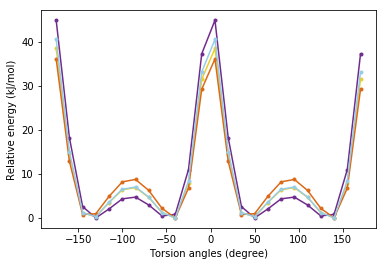

In [8]:
colors = chemi._KELLYS_COLORS
for i in range(4):
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), color=colors[i])
    plt.plot(all_angles[i][12:] + all_angles[i][:12], np.concatenate((all_energies[i][12:], all_energies[i][:12])), '.', color=colors[i])
plt.xlabel('Torsion angles (degree)')
plt.ylabel('Relative energy (kJ/mol)')
plt.savefig('biphenyl_mm_torsion_scan.pdf', bbox_inches='tight')

In [10]:
# From Josh - constrained minimzation 

def compute_dihedral(xyz, indices):
    """Copied from mdtraj, except without calls to a non-python distance library,
    and assuming we dont have to deal with periodic stuff"""
    
    a,b,c,d = indices
    b1 = xyz[b] - xyz[a]
    b2 = xyz[c] - xyz[b]
    b3 = xyz[d] - xyz[c]
    
    c1 = np.cross(b2, b3) # bc x cd
    c2 = np.cross(b1, b2) # ab x bc

    p1 = np.sum(b1 * c1)
    p1 *= np.sum(b2 * b2) ** 0.5
    p2 = np.sum(c1 * c2)

    return np.arctan2(p1, p2)

def unflatten(flat_xyz):
    N = int(len(flat_xyz) / 3)
    return np.reshape(flat_xyz, (N, 3))

def set_positions(xyz):
    simulation.context.setPositions(xyz)
    
E_unit = simulation.context.getState(getEnergy=True).getPotentialEnergy().unit
F_unit = simulation.context.getState(getForces=True).getForces(asNumpy=True).unit
    
def get_energy(xyz):
    set_positions(xyz)
    return simulation.context.getState(getEnergy=True).getPotentialEnergy() / E_unit

def get_forces(xyz):
    set_positions(xyz)
    return simulation.context.getState(getForces=True).getForces(asNumpy=True) / F_unit

def fxn_to_minimize(flat_xyz):
    return get_energy(unflatten(flat_xyz))

def jacobian_of_fxn(flat_xyz):
    return - get_forces(unflatten(flat_xyz))



In [18]:
# Get a system
integrator = mm.VerletIntegrator(1*unit.femtosecond)
platform = mm.Platform.getPlatformByName("Reference")

simulation = simulations[0]
xyz = off_molecules[0].conformers[0].in_units_of(unit.nanometer)
simulation.context.setPositions(xyz)
flat_xyz = (xyz / unit.nanometer).flatten()

In [27]:
fxn_to_minimize(flat_xyz), jacobian_of_fxn(flat_xyz)

(387.15155029296875, array([[  512.05950928,  -267.55859375,  -463.5881958 ],
        [  627.47064209,  -336.04086304,  -258.81332397],
        [ -274.18374634,   151.41256714,   -53.90885544],
        [  -55.53871918,    24.17018318,   216.37582397],
        [ -774.40844727,   501.77185059,  -255.8913269 ],
        [ -272.22390747,    56.24277878,   910.92425537],
        [-1039.71350098,   538.46484375,   678.17028809],
        [-1057.34436035,   570.05255127,   631.75488281],
        [ -352.51309204,   189.51731873,   217.09686279],
        [  666.59411621,  -359.22131348,  -419.15820312],
        [  408.62518311,  -219.37353516,  -256.40472412],
        [ 1291.38452148,  -682.84436035,  -810.90246582],
        [  120.70637512,   -62.97424316,   -73.27740479],
        [ 1100.31445312,  -430.5269165 ,  -592.0189209 ],
        [  937.62695312,  -654.86444092,  -674.35327148],
        [   36.8917923 ,   -16.82372665,   -79.7412262 ],
        [  -21.63752747,    11.07032776,    26.85806

In [28]:
from functools import partial

def dihedral_constraint(flat_xyz, target_dihedral=0.0):
    """equality constraint: want the output of this function to be 0"""
    xyz = unflatten(flat_xyz)
    return compute_dihedral(xyz, torsion_indices) - target_dihedral

In [29]:
from scipy.optimize import minimize

def form_eq_constraint(target_dihedral):
    """adapted from scipy documentation
    https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp
    """
    
    fun = partial(dihedral_constraint, target_dihedral=target_dihedral)

    eq_cons = {'type': 'eq',
               'fun' : fun,
               'jac' : grad(fun)}
    return eq_cons

In [31]:
target_dihedral = 0
torsion_indices = dih
eq_cons = form_eq_constraint(target_dihedral)
eq_cons['jac'](flat_xyz)

array([ -3.9966948 ,  -7.24618613,  -0.23349414,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         4.29775471,   7.0672432 ,   0.8681694 ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         7.99896673,  14.15260393,   0.76520708,  -8.30002664,
       -13.973661  ,  -1.39988234,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [32]:
from scipy.optimize import show_options
show_options('minimize', method='SLSQP')

Minimize a scalar function of one or more variables using Sequential
Least SQuares Programming (SLSQP).

Options
-------
ftol : float
    Precision goal for the value of f in the stopping criterion.
eps : float
    Step size used for numerical approximation of the Jacobian.
disp : bool
    Set to True to print convergence messages. If False,
    `verbosity` is ignored and set to 0.
maxiter : int
    Maximum number of iterations.


In [33]:
result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
               constraints=[eq_cons], options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.0566101074219
            Iterations: 168
            Function evaluations: 593
            Gradient evaluations: 168


In [34]:
result = minimize(fxn_to_minimize, flat_xyz, method='SLSQP', jac=jacobian_of_fxn,
                options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 294.41180419921875
            Iterations: 178
            Function evaluations: 578
            Gradient evaluations: 178
